# Configure Phenotype Process Params

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.shared.segment_cellpose import estimate_diameters
from lib.shared.segment_cellpose import segment_cellpose
from lib.phenotype_process.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.phenotype_process.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)

## SET PARAMETERS

### Parameters for testing phenotype processing

- `TEST_WELL`, `TEST_TILE`: Well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [3]:
# parameters for testing
TEST_WELL = "A1"
TEST_TILE = 1
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["DAPI", "COXIV", "CENPA", "WGA"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_yellow"]

# parameters for feature extraction
FOCI_CHANNEL = 2

Loading test image...
Applying illumination correction...
Example corrected image:


/lab/barcheese01/rkern/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/microfilm/microplot.py:725: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  self.fig, self.ax = plt.subplots(


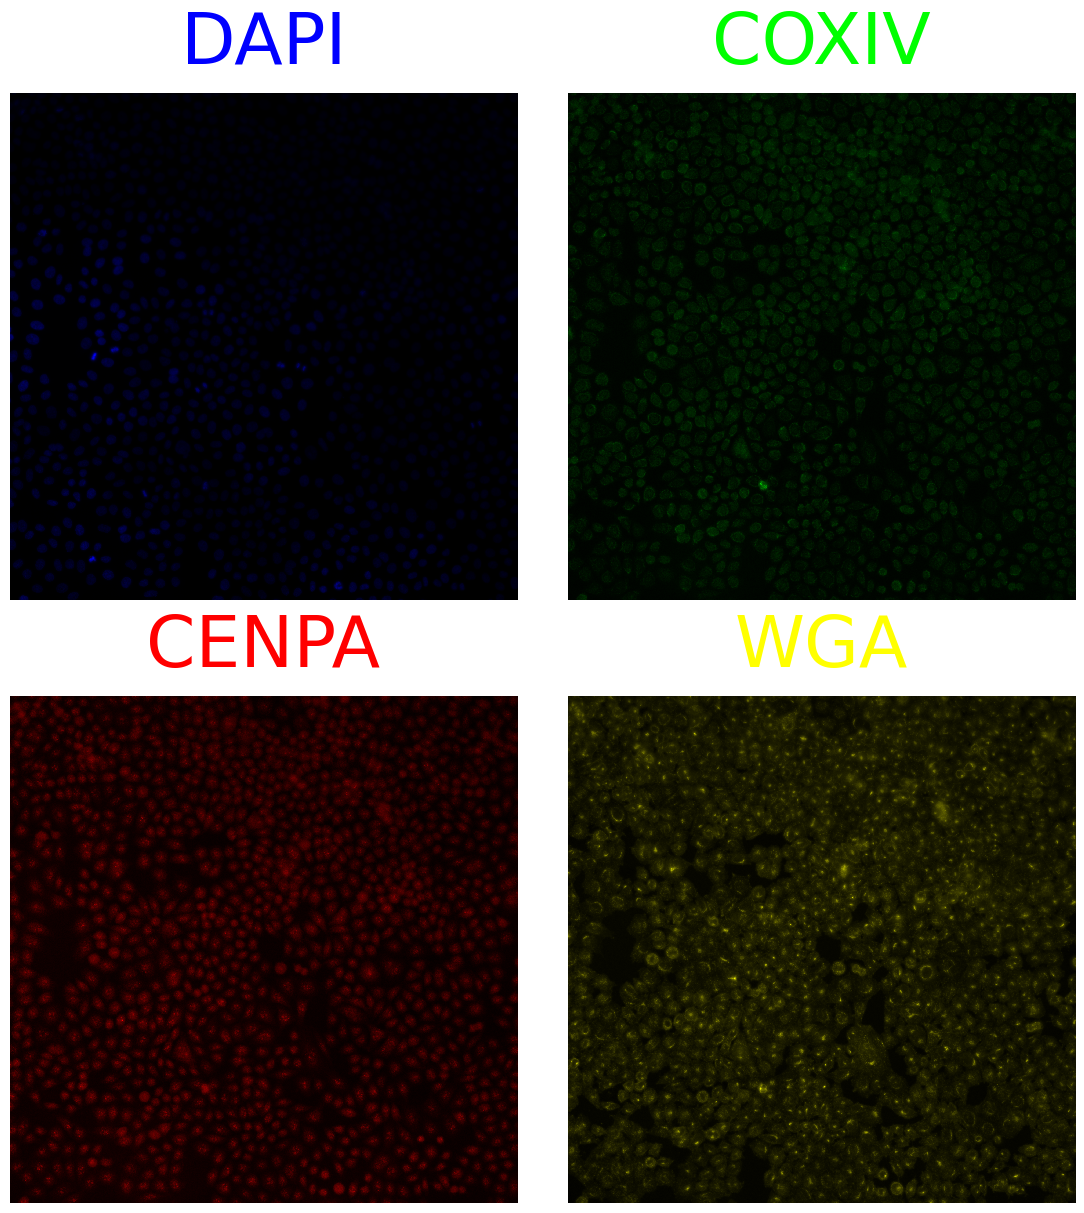

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## SET PARAMETERS

### Segmentation

- `CYTO_CHANNEL`: The name of the cytoplasmic channel in your image stack. Typically the channel that best outlines cell boundaries.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

In [5]:
# Define parameters for CellPose segmentation
CYTO_CHANNEL = "COXIV"
CYTO_MODEL = "cyto3"
FLOW_THRESHOLD = 0.4
CELLPROB_THRESHOLD = 0
GPU = False

# Derive DAPI and CYTO indexes
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

In [6]:
print("Estimating optimal cell and nuclei diameters...")
NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
    corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    cyto_model=CYTO_MODEL,
)

Estimating optimal cell and nuclei diameters...


/lab/barcheese01/rkern/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


Estimating nuclei diameters...


/lab/barcheese01/rkern/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_

Estimated nuclear diameter: 41.0 pixels
Estimating cell diameters...
Estimated cell diameter: 54.1 pixels


Segmenting cells...


found 1244 nuclei before removing edges
found 1205 cells before removing edges


removing edges


found 1169 nuclei before reconciling
found 1121 cells before reconciling


reconciling masks with method how=consensus


found 1076 nuclei/cells after reconciling


Number of nuclei segmented: 1076
Number of cells segmented: 1076
Example microplots for DAPI channel and nuclei segmentation:


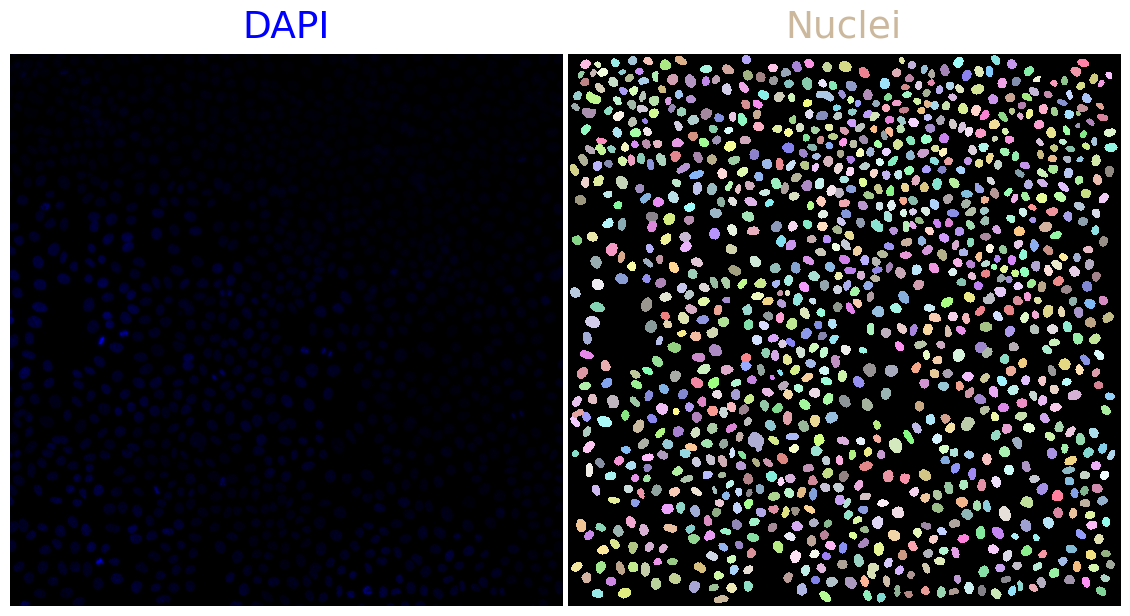

Example microplots for merged channels and cells segmentation:


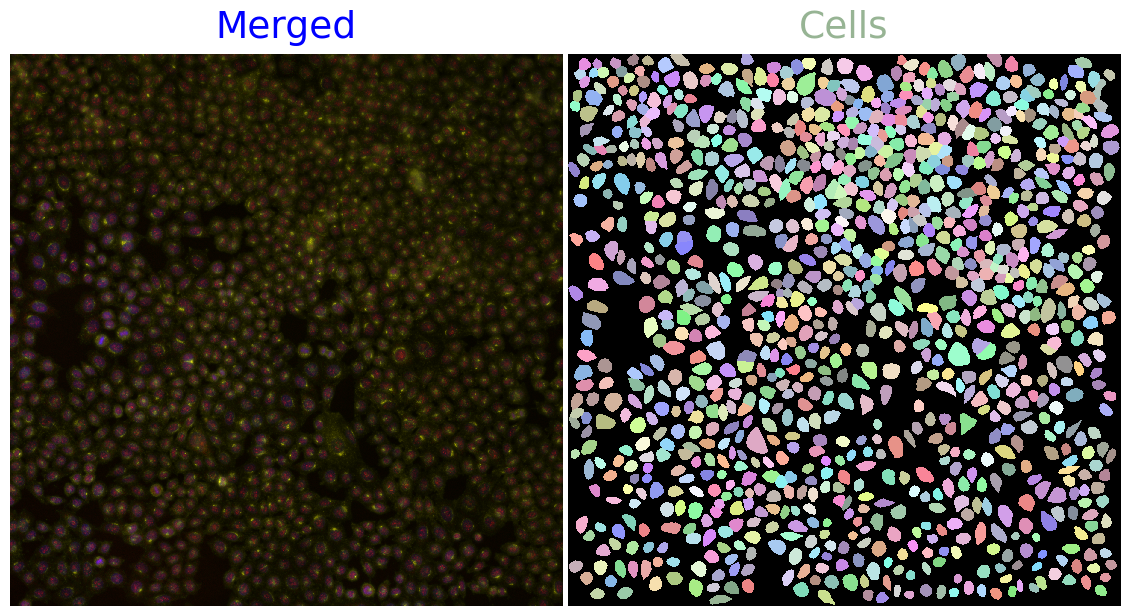

Example microplot for phenotype data annotated with segmentation:


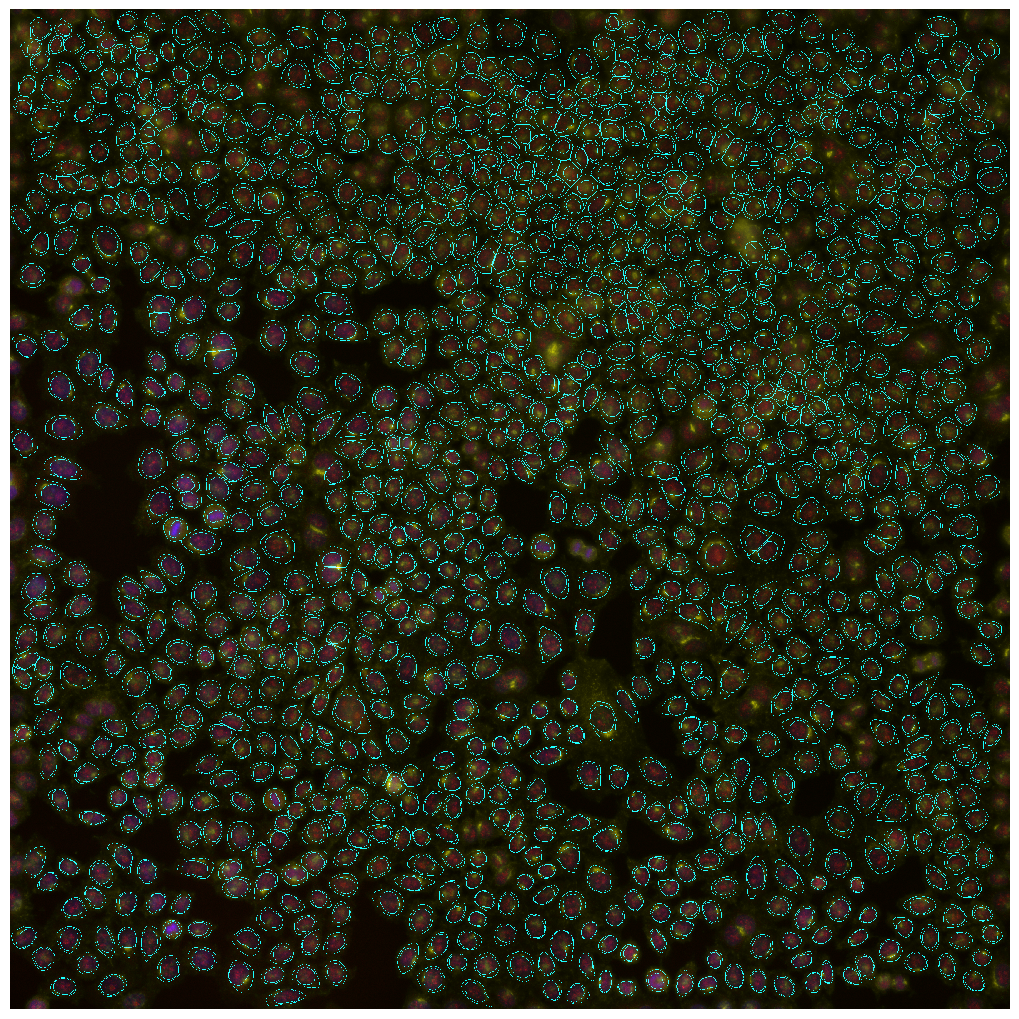

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 1076


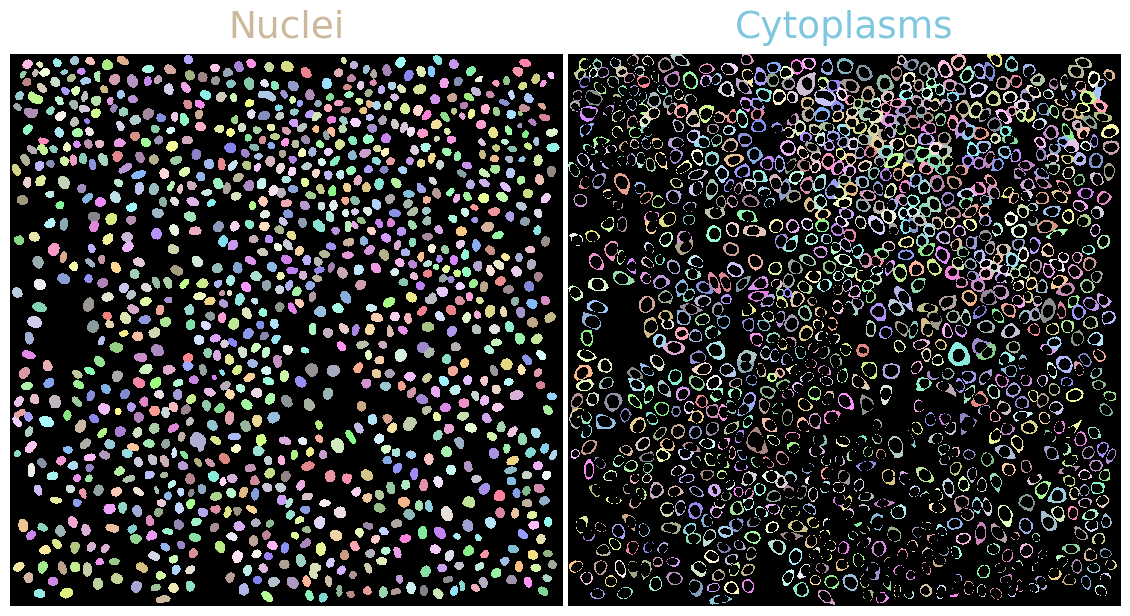

In [7]:
print("Segmenting cells...")
nuclei, cells = segment_cellpose(
    data=corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cellpose_kwargs=dict(
        flow_threshold=FLOW_THRESHOLD,
        cellprob_threshold=CELLPROB_THRESHOLD,
    ),
    cyto_model=CYTO_MODEL,
    gpu=GPU,
)

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        corrected_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        corrected_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS,
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(corrected_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

In [8]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    corrected_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

Extracting phenotype features:


label  nucleus_DAPI_int  nucleus_COXIV_int  nucleus_CENPA_int  \
0         1           1064582             472462             436656   
1         2            766634             359823             357697   
2         3            879395             361064             413885   
3         4            887190             305430             366282   
4         5            871536             504080             479012   
...     ...               ...                ...                ...   
1071   1072           2183339             337028             409159   
1072   1073           3423051             380775             465328   
1073   1074           1905431             391294             457403   
1074   1075           2605368             337668             445987   
1075   1076           3719045             427966             593033   

      nucleus_WGA_int  nucleus_DAPI_mean  nucleus_COXIV_mean  \
0             3380839         824.618125          365.965918   
1             2653496         575.551051          270.137387   
2             3831495         544.854399          223.707559   
3             3146173         694.745497          239.177760   
4             4187294         532.398290          307.929139   
...               ...                ...                 ...   
1071          3304359        1626.929210          251.138599   
1072          3774795        3653.202775          406.376734   
1073          3591969        1119.524677          229.902468   
1074          3570863        2069.394758          268.203336   
1075          4066838        2237.692539          257.500602   

      nucleus_CENPA_mean  nucleus_WGA_mean  nucleus_DAPI_std  ...  \
0             338.230829       2618.775368        157.915539  ...   
1             268.541291       1992.114114         99.417196  ...   
2             256.434325       2373.912639         97.330671  ...   
3             286.830070       2463.722005        130.738809  ...   
4             292.615761       2557.907147         87.831579  ...   
...                  ...               ...               ...  ...   
1071          304.887481       2462.264531        284.334208  ...   
1072          496.614728       4028.596585       1007.959524  ...   
1073          268.744418       2110.440071        231.244335  ...   
1074          354.239079       2836.269261        329.088556  ...   
1075          356.818893       2446.954272        449.816561  ...   

      cell_number_neighbors_1  cell_percent_touching_1  \
0                           0                      0.0   
1                           0                      0.0   
2                           0                      0.0   
3                           0                      0.0   
4                           0                      0.0   
...                       ...                      ...   
1071                        0                      0.0   
1072                        0                      0.0   
1073                        0                      0.0   
1074                        0                      0.0   
1075                        0                      0.0   

      cell_first_neighbor_distance  cell_second_neighbor_distance  \
0                        74.589790                      85.930752   
1                        58.388503                      73.049786   
2                        68.597145                      90.413479   
3                        55.248734                      63.879987   
4                        66.745028                      67.335872   
...                            ...                            ...   
1071                     60.102602                      61.651212   
1072                     54.757588                      74.914462   
1073                     70.353710                      85.448542   
1074                     60.102602                      71.421276   
1075                     59.399235                      71.227955   

      cell_angle_between_neig

In [9]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_foci_area',
 'cell_foci_count',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',

## Add phenotype module parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [10]:
# Add phenotype_process section
config["phenotype_process"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "nuclei_diameter": NUCLEI_DIAMETER,
    "cell_diameter": CELL_DIAMETER,
    "flow_threshold": FLOW_THRESHOLD,
    "cellprob_threshold": CELLPROB_THRESHOLD,
    "cyto_model": CYTO_MODEL,
    "gpu": GPU,
    "mode": None,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)